Both CGCNN and GP modeling were too good at making predictions on CatHub's validation set. We double-checked the splitting and don't see any obvious leakage into the training set. This notebook documents our journey into figuring this out.

# Load data

In [1]:
import pickle


# Load data
splits = {}
for dataset in ['cathub', 'gasdb']:
    with open('../splits_%s.pkl' % dataset, 'rb') as file_handle:
        _splits = pickle.load(file_handle)

    # Parse data
    docs_train = _splits['docs_train']
    docs_val = _splits['docs_val']
    fingerprints_train = _splits['fingerprints_train']
    fingerprints_val = _splits['fingerprints_val']
    splits[dataset] = _splits

# Lipschitz distributions
First, make a function to calculate the lipschitz distribution of a dataset

In [2]:
import warnings
import itertools
import multiprocess
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm_notebook


def calculate_lipschitz(_docs, _features, suffix, force=False, processes=8):
    '''
    Calculates the Lipschitz values of a series of data.
    
    Args:
        _docs       A list of dictionaries of parsed information
        _features   A numpy array of features. Should map to `docs`
        suffix      A string indicating the suffix you want to use
                    for the cache of results that this function will use
        force       A Boolean indicating whether or not you want to force
                    this function to recalculate the Lipschitz values
                    (as opposed to just loading a cache).
        processes   An integeter indicating how many processes you want
                    to use whem multithreading
    Returns:
        lips    A pandas.Series of all the Lipschitz values for each
                combination of data points
    '''
    # If we're not forcing a re-do, then try to just load the data
    if force is False:
        try:
            with h5py.File('lips_%s.hdf5' % suffix, 'r') as h5_handle:
                lips = h5_handle['lips']
                lips = pd.Series(lips)
            return lips

        # If the file is not there, then move on to the rest of this code,
        # which will do the calculation
        except OSError:
            pass


    # Push these big objects to global space for faster process sharing
    global docs
    global features
    docs = _docs
    features = _features

    def __calculate_lipschitz(indices):
        '''
        Calculates the Lipschitz value between document with index i
        and document with index j, where indices=(i, j). We make a
        function so that we can multimap it.

        Args:
            indices 2-tuple contaning the indices of the documents you
                    want to get the Lipschitz value for
        Returns:
            lipschitz   The Lipschitz value between document i and j
        '''
        i, j = indices
        energy_diff = docs[i]['energy'] - docs[j]['energy']
        feature_diff = features[i, :] - features[j, :]
        lipschitz = abs(energy_diff) / np.linalg.norm(feature_diff, 2)
        return lipschitz

    # Figure out all the 2-pair combinations
    index_combinations = itertools.combinations(range(len(docs)), 2)
    n_docs = len(docs)
    n_combinations = int((n_docs * (n_docs-1))/2)

    # Ignore divide-by-zero warnings
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore', category=RuntimeWarning)
        # Multithreaded calculations
        with multiprocess.Pool(processes=processes, maxtasksperchild=1000) as pool:
            iterator = pool.imap(__calculate_lipschitz, index_combinations, chunksize=10000)
            lips = list(tqdm_notebook(iterator, total=n_combinations, unit_scale=True))

    # Filter out things with infinity
    lips = [lip for lip in lips if lip != np.inf]

    # Save the data
    with h5py.File('lips_%s.hdf5' % suffix, 'w') as h5_handle:
        h5_handle.create_dataset('lips', data=lips, dtype='f', compression='gzip')
        lips = pd.Series(lips)

    # Clean up and output
    del globals()['docs']
    del globals()['features']
    return lips

In [3]:
import pickle


# Load data
lips_val = {}
lips_train = {}
for dataset in ['cathub', 'gasdb']:

    # Calculate Lipschitz distribution
    _lips_val = calculate_lipschitz(docs_val, fingerprints_val, '%s_val' % dataset)
    _lips_train = calculate_lipschitz(docs_train, fingerprints_train, '%s_train' % dataset)

    # We accidentally forgot to drop NaN values. Do so here.
    _lips_val = _lips_val.dropna()
    _lips_train = _lips_train.dropna()

    lips_val[dataset] = _lips_val
    lips_train[dataset] = _lips_train

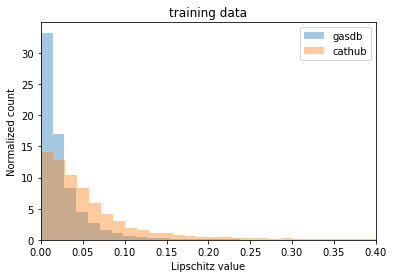

In [4]:
%matplotlib inline
import seaborn as sns


# Plot the distributions
ax = sns.distplot(lips_train['gasdb'], kde=False,
                  bins=1000,
                  norm_hist=True,
                  label='gasdb',
                 )
ax = sns.distplot(lips_train['cathub'], kde=False,
                  bins=100,
                  norm_hist=True,
                  label='cathub',
                 )

# Format
plot_lims = (0, 0.4)
_ = ax.set_xlim(plot_lims)
_ = ax.set_xlabel('Lipschitz value')
_ = ax.set_ylabel('Normalized count')
_ = ax.set_title('training data')
_ = ax.legend()

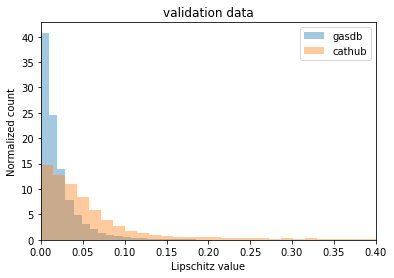

In [5]:
%matplotlib inline
import seaborn as sns


# Plot the distributions
ax = sns.distplot(lips_val['gasdb'], kde=False,
                  bins=1000,
                  norm_hist=True,
                  label='gasdb',
                 )
ax = sns.distplot(lips_val['cathub'], kde=False,
                  bins=100,
                  norm_hist=True,
                  label='cathub',
                 )

# Format
plot_lims = (0, 0.4)
_ = ax.set_xlim(plot_lims)
_ = ax.set_xlabel('Lipschitz value')
_ = ax.set_ylabel('Normalized count')
_ = ax.set_title('validation data')
_ = ax.legend()

Hm. Looks like Cathub data is actually better looking than GASdb. This means that it should be easier for models to make predictions from Cathub data than GASdb data, which is consistent with what we saw before. Let's keep doing with some other distance metrics.
# RBF distances

Calculation and plot timing for val set of gasdb:
CPU times: user 1.51 s, sys: 160 ms, total: 1.67 s
Wall time: 1.67 s
CPU times: user 9.08 s, sys: 220 ms, total: 9.3 s
Wall time: 9.3 s
Calculation and plot timing for val set of cathub:
CPU times: user 560 ms, sys: 51.8 ms, total: 612 ms
Wall time: 611 ms
CPU times: user 2.41 s, sys: 64 ms, total: 2.48 s
Wall time: 2.47 s
Calculation and plot timing for train set of gasdb:
CPU times: user 38.2 s, sys: 4.46 s, total: 42.6 s
Wall time: 42.6 s
CPU times: user 4min 6s, sys: 12.5 s, total: 4min 18s
Wall time: 4min 18s
Calculation and plot timing for train set of cathub:
CPU times: user 16 s, sys: 1.8 s, total: 17.8 s
Wall time: 17.8 s
CPU times: user 1min 9s, sys: 2.1 s, total: 1min 11s
Wall time: 1min 11s


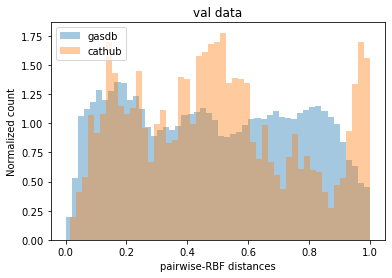

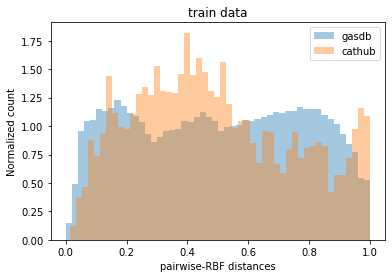

In [14]:
%matplotlib inline
import numpy as np
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate RBF distances
for partition in ['val', 'train']:
    fig = plt.figure()
    for dataset in ['gasdb', 'cathub']:
        _splits = splits[dataset]
        fps = _splits['fingerprints_%s' % partition]
        scale = 55.
        print('Calculation and plot timing for %s set of %s:' % (partition, dataset))
        %time distances = scipy.exp(-cdist(fps, fps, 'sqeuclidean') / scale**2)

        # Plot
        %time ax = sns.distplot(distances.flatten(), kde=False, norm_hist=True, label=dataset)

    # Format
    _ = ax.set_xlabel('pairwise-RBF distances')
    _ = ax.set_ylabel('Normalized count')
    _ = ax.set_title('%s data' % partition)
    _ = ax.legend()

Interesting. Looks like GASdb is more diverse than Cathub by a little bit... maybe? Let's verify using another distance metric.
# Cosine similarity

Calculation and plot timing for val set of gasdb:
CPU times: user 411 ms, sys: 188 ms, total: 599 ms
Wall time: 443 ms
CPU times: user 9.3 s, sys: 216 ms, total: 9.52 s
Wall time: 9.52 s
Calculation and plot timing for val set of cathub:
CPU times: user 182 ms, sys: 99.9 ms, total: 282 ms
Wall time: 155 ms
CPU times: user 2.28 s, sys: 99.9 ms, total: 2.38 s
Wall time: 2.37 s
Calculation and plot timing for train set of gasdb:
CPU times: user 8.35 s, sys: 3.86 s, total: 12.2 s
Wall time: 11.2 s
CPU times: user 4min 12s, sys: 12.3 s, total: 4min 24s
Wall time: 4min 24s
Calculation and plot timing for train set of cathub:
CPU times: user 3.31 s, sys: 1.74 s, total: 5.05 s
Wall time: 4.53 s
CPU times: user 1min 9s, sys: 2.21 s, total: 1min 11s
Wall time: 1min 11s


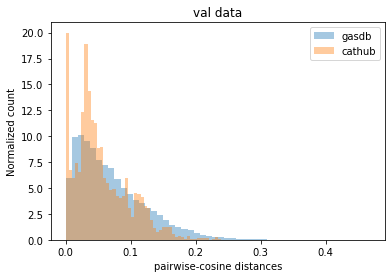

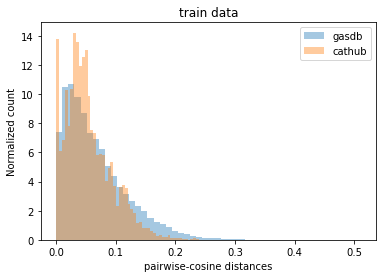

In [7]:
%matplotlib inline
import scipy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate cosine distances
for partition in ['val', 'train']:
    fig = plt.figure()
    for dataset in ['gasdb', 'cathub']:
        _splits = splits[dataset]
        fps = _splits['fingerprints_%s' % partition]
        print('Calculation and plot timing for %s set of %s:' % (partition, dataset))
        %time distances = 1 - cosine_similarity(fps, fps)

        # Plot
        %time ax = sns.distplot(distances.flatten(), kde=False, norm_hist=True, label=dataset)

    # Format
    _ = ax.set_xlabel('pairwise-cosine distances')
    _ = ax.set_ylabel('Normalized count')
    _ = ax.set_title('%s data' % partition)
    _ = ax.legend()

Looks like GASdb is a bit more diverse wrt cosine distances, but not by that much.